In [ ]:
!pip install medmnist
!pip install ACSConv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=604af6584d9448405371b87d318db1aa088f1bd9bcd6a2177a75732b305373ef
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.7 MB/s eta 0:00:00
  Created wheel for ACSConv: filename=ACSConv-0.1.1-py3-none-any.whl size=24182 sha256=d937cba74c5701437197128ba53269dd746f486e96a560ccbb1633c0ad399c0b
  Stored in directory: /root/.cache/pip/wheels/0e/b1/ef/43fe6db442ef60fc6a8c7f98f330672eeca58463ebef542e62
Successfully built ACSConv


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset

In [ ]:
data_flag = 'dermamnist'
download = True

# Hyperparamaters
NUM_EPOCHS = 15
BATCH_SIZE = 128
lr = 0.001

info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
DataClass

medmnist.dataset.DermaMNIST

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [ ]:
# preprocessing
#transform the data
data_transform = transforms.Compose([
    transforms.ToTensor(), # for PyTorch
    transforms.Normalize(mean=[.5], std=[.5]) # normalization
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download) # no transform

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 19725078/19725078 [00:12<00:00, 1608662.13it/s]


Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY 4.0
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 1003
    Root location: /roo

In [ ]:
# visualization

train_dataset.montage(length=1) #length = n, n*n display

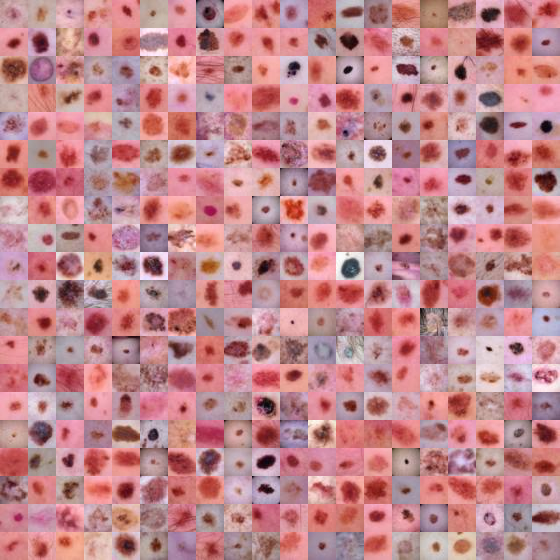

In [ ]:
# montage
train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [ ]:
# define a simple CNN model

class CNN_2D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_2D, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3), # convolutional layer
            nn.BatchNorm2d(16),
            nn.ReLU()) # max(0,x)

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer6 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        print(x.shape)
        x = self.layer6(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = self.fc(x)
        print(x.shape)
        return x

# call your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_2D(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [ ]:
# train
loss_values = []  # list to store loss values

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}...')
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    model.to(device)
    epoch_loss = 0  # variable to store cumulative loss in each epoch

    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs) #predictions

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # add the batch loss to the epoch's cumulative loss

    epoch_loss /= len(train_loader)  # average the epoch's cumulative loss over all batches
    loss_values.append(epoch_loss)  # save the epoch loss

Epoch 1/15...


  0%|          | 0/55 [00:00<?, ?it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  2%|▏         | 1/55 [00:00<00:35,  1.50it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:01<00:27,  1.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:01<00:20,  2.48it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:02<00:17,  2.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:02<00:15,  3.22it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:02<00:13,  3.46it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:02<00:12,  3.66it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:02<00:12,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:03<00:11,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:03<00:11,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:03<00:10,  4.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:03<00:10,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:04<00:10,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:04<00:09,  4.05it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:04<00:09,  4.03it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:04<00:09,  4.04it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:05<00:09,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:05<00:08,  4.06it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:05<00:08,  4.01it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:05<00:08,  4.05it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:06<00:08,  4.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:06<00:07,  4.04it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:06<00:07,  4.00it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:06<00:07,  4.08it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:07<00:07,  4.14it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:07<00:06,  4.20it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:07<00:06,  4.07it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:07<00:06,  4.07it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:08<00:06,  4.11it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:08<00:05,  4.09it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:08<00:05,  4.11it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:08<00:05,  4.04it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:09<00:05,  4.07it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:09<00:04,  4.07it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:09<00:04,  4.14it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:09<00:04,  4.09it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:10<00:04,  4.06it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:10<00:03,  4.14it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:10<00:03,  4.08it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:10<00:03,  4.00it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:11<00:03,  4.07it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:11<00:02,  4.06it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:11<00:02,  4.06it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:11<00:02,  3.63it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:12<00:02,  3.22it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:12<00:02,  3.05it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:13<00:02,  2.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:13<00:02,  2.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:13<00:01,  2.76it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:14<00:01,  2.67it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:14<00:00,  2.75it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:15<00:00,  3.05it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:15<00:00,  3.57it/s]


torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])
Epoch 2/15...


  2%|▏         | 1/55 [00:00<00:12,  4.32it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:00<00:12,  4.18it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:00<00:12,  4.06it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:00<00:12,  4.08it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:01<00:12,  4.03it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:01<00:12,  4.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:01<00:12,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:01<00:11,  4.00it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:02<00:11,  4.05it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:02<00:11,  4.05it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:02<00:11,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:02<00:10,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:03<00:10,  4.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:03<00:10,  4.06it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:03<00:09,  4.01it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:03<00:09,  4.04it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:04<00:09,  4.09it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:04<00:08,  4.14it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:04<00:08,  4.07it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:04<00:08,  4.03it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:05<00:08,  4.10it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:05<00:08,  4.07it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:05<00:07,  4.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:05<00:07,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:06<00:07,  4.08it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:06<00:07,  4.09it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:06<00:07,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:06<00:06,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:07<00:06,  4.05it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:07<00:06,  4.07it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:07<00:06,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:07<00:05,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:08<00:05,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:08<00:05,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:08<00:05,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:08<00:04,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:09<00:04,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:09<00:04,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:09<00:04,  3.43it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:10<00:04,  3.05it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:10<00:04,  2.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:11<00:04,  2.74it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:11<00:04,  2.71it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:11<00:04,  2.63it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:12<00:03,  2.59it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:12<00:02,  2.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:13<00:02,  3.14it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:13<00:01,  3.35it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:13<00:01,  3.53it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:13<00:01,  3.67it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 95%|█████████▍| 52/55 [00:14<00:00,  3.70it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:14<00:00,  3.72it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:14<00:00,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:14<00:00,  3.71it/s]


torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])
Epoch 3/15...


  2%|▏         | 1/55 [00:00<00:13,  4.00it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:00<00:12,  4.11it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:00<00:12,  4.13it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:00<00:12,  4.12it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:01<00:12,  4.05it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:01<00:12,  4.07it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:01<00:11,  4.03it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:01<00:11,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:02<00:11,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:02<00:11,  4.05it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:02<00:11,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:02<00:10,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:03<00:10,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:03<00:10,  4.00it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:03<00:10,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:03<00:09,  4.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:04<00:09,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:04<00:09,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:04<00:09,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:04<00:08,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:05<00:08,  4.00it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:05<00:08,  4.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:05<00:08,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:06<00:07,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:06<00:07,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:06<00:07,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:06<00:07,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:07<00:06,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:07<00:06,  4.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:07<00:06,  4.03it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:07<00:05,  4.03it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:08<00:06,  3.42it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:08<00:06,  3.17it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:08<00:07,  2.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:09<00:07,  2.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:09<00:06,  2.73it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:10<00:06,  2.67it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:10<00:06,  2.63it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:11<00:05,  2.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:11<00:04,  3.10it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:11<00:03,  3.30it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:11<00:03,  3.47it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:12<00:03,  3.58it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:12<00:02,  3.76it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:12<00:02,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:12<00:02,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:13<00:01,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:13<00:01,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:13<00:01,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:13<00:01,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 95%|█████████▍| 52/55 [00:14<00:00,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:14<00:00,  4.04it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:14<00:00,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:14<00:00,  3.70it/s]


torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])
Epoch 4/15...


  2%|▏         | 1/55 [00:00<00:13,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:00<00:13,  4.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:00<00:13,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:00<00:12,  4.01it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:01<00:12,  4.03it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:01<00:12,  4.04it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:01<00:11,  4.01it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:01<00:11,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:02<00:11,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:02<00:11,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:02<00:11,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:03<00:10,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:03<00:10,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:03<00:10,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:03<00:10,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:04<00:09,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:04<00:09,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:04<00:09,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:04<00:09,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:05<00:09,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:05<00:08,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:05<00:08,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:05<00:08,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:06<00:07,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:06<00:08,  3.51it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:06<00:09,  3.12it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:07<00:09,  2.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:07<00:09,  2.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:08<00:09,  2.70it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:08<00:09,  2.63it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:08<00:09,  2.59it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:09<00:07,  2.76it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:09<00:06,  3.04it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:10<00:06,  3.23it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:10<00:05,  3.32it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:10<00:05,  3.51it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:10<00:04,  3.63it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:11<00:04,  3.74it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:11<00:04,  3.74it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:11<00:03,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:11<00:03,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:12<00:03,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:12<00:02,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:12<00:02,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:12<00:02,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:13<00:02,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:13<00:01,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:13<00:01,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:13<00:01,  4.03it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:14<00:00,  4.01it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 95%|█████████▍| 52/55 [00:14<00:00,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:14<00:00,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:14<00:00,  4.00it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:15<00:00,  3.66it/s]


torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])
Epoch 5/15...


  2%|▏         | 1/55 [00:00<00:13,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:00<00:13,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:00<00:13,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:01<00:13,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:01<00:12,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:01<00:12,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:01<00:12,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:02<00:12,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:02<00:11,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:02<00:11,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:02<00:10,  4.01it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:03<00:10,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:03<00:10,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:03<00:10,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:03<00:10,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:04<00:09,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:04<00:09,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:04<00:10,  3.44it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:05<00:11,  3.12it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:05<00:11,  2.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:05<00:12,  2.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:06<00:12,  2.70it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:06<00:12,  2.64it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:07<00:11,  2.65it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:07<00:10,  2.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:07<00:09,  3.10it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:08<00:08,  3.32it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:08<00:07,  3.48it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:08<00:06,  3.66it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:08<00:06,  3.77it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:09<00:06,  3.80it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:09<00:05,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:09<00:05,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:09<00:05,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:10<00:04,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:10<00:04,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:10<00:04,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:10<00:04,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:11<00:03,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:11<00:03,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:11<00:03,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:12<00:03,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:12<00:02,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:12<00:02,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:12<00:02,  4.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:13<00:01,  4.04it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:13<00:01,  4.08it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:13<00:01,  4.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:13<00:01,  4.03it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:13<00:00,  4.07it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 95%|█████████▍| 52/55 [00:14<00:00,  4.04it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:14<00:00,  4.06it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:14<00:00,  4.00it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:14<00:00,  3.68it/s]


torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])
Epoch 6/15...


  2%|▏         | 1/55 [00:00<00:13,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:00<00:13,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:00<00:13,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:01<00:13,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:01<00:12,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:01<00:12,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:01<00:12,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:02<00:12,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:02<00:11,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:02<00:11,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:02<00:12,  3.58it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:03<00:13,  3.19it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:03<00:14,  2.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:04<00:14,  2.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:04<00:14,  2.75it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:04<00:14,  2.67it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:05<00:14,  2.64it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:05<00:13,  2.69it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:06<00:11,  2.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:06<00:10,  3.23it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:06<00:09,  3.39it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:07<00:09,  3.43it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:07<00:08,  3.61it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:07<00:08,  3.63it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:07<00:07,  3.69it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:08<00:07,  3.71it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:08<00:07,  3.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:08<00:06,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:08<00:06,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:09<00:06,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:09<00:05,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:09<00:05,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:09<00:05,  4.00it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:10<00:04,  4.04it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:10<00:04,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:10<00:04,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:10<00:04,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:11<00:04,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:11<00:03,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:11<00:03,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:11<00:03,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:12<00:03,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:12<00:02,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:12<00:02,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:12<00:02,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:13<00:02,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:13<00:01,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:13<00:01,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:13<00:01,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:14<00:01,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 95%|█████████▍| 52/55 [00:14<00:00,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:14<00:00,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:14<00:00,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:15<00:00,  3.64it/s]


torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])
Epoch 7/15...


  2%|▏         | 1/55 [00:00<00:13,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:00<00:13,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:00<00:13,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:01<00:14,  3.48it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:01<00:16,  3.12it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:01<00:16,  2.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:02<00:17,  2.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:02<00:17,  2.76it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:03<00:16,  2.71it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:03<00:17,  2.65it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:03<00:17,  2.58it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:04<00:14,  2.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:04<00:13,  3.11it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:04<00:11,  3.37it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:05<00:11,  3.47it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:05<00:10,  3.56it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:05<00:10,  3.66it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:05<00:09,  3.76it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:06<00:09,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:06<00:08,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:06<00:08,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:06<00:08,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:07<00:07,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:07<00:07,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:07<00:07,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:08<00:07,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:08<00:06,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:08<00:06,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:08<00:06,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:09<00:06,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:09<00:05,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:09<00:05,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:09<00:05,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:10<00:05,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:10<00:04,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:10<00:04,  4.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:10<00:04,  4.01it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:11<00:04,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:11<00:03,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:11<00:03,  4.01it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:11<00:03,  4.03it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:12<00:03,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:12<00:02,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:12<00:02,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:12<00:02,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:13<00:02,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:13<00:01,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:13<00:01,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:13<00:01,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:14<00:01,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 95%|█████████▍| 52/55 [00:14<00:00,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:14<00:00,  3.25it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:15<00:00,  3.56it/s]


torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])
Epoch 8/15...


  0%|          | 0/55 [00:00<?, ?it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  2%|▏         | 1/55 [00:00<00:21,  2.54it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:00<00:20,  2.53it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:01<00:20,  2.51it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:01<00:20,  2.55it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:02<00:18,  2.70it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:02<00:15,  3.01it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:02<00:14,  3.26it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:03<00:13,  3.43it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:03<00:12,  3.54it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:03<00:12,  3.62it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:03<00:11,  3.73it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:04<00:10,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:04<00:10,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:04<00:10,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:04<00:09,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:05<00:09,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:05<00:09,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:05<00:09,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:05<00:09,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:06<00:08,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:06<00:08,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:06<00:08,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:06<00:08,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:07<00:07,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:07<00:07,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:07<00:07,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:07<00:06,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:08<00:06,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:08<00:06,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:08<00:06,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:08<00:05,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:09<00:05,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:09<00:05,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:09<00:05,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:09<00:04,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:10<00:04,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:10<00:04,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:10<00:04,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:10<00:03,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:11<00:03,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:11<00:03,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:11<00:03,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:12<00:02,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:12<00:02,  3.75it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:12<00:02,  3.24it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:13<00:02,  2.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:13<00:02,  2.80it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:13<00:02,  2.68it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:14<00:01,  2.66it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:14<00:01,  2.55it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:15<00:00,  2.65it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:15<00:00,  2.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:15<00:00,  3.45it/s]


torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])
Epoch 9/15...


  2%|▏         | 1/55 [00:00<00:13,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:00<00:13,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:00<00:13,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:01<00:13,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:01<00:12,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:01<00:12,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:01<00:12,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:02<00:12,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:02<00:11,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:02<00:11,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:02<00:11,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:03<00:11,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:03<00:10,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:03<00:10,  3.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:03<00:10,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:04<00:09,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:04<00:09,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:04<00:09,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:04<00:09,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:05<00:09,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:05<00:08,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:05<00:08,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:05<00:08,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:06<00:08,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:06<00:07,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:06<00:07,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:06<00:07,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:07<00:06,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:07<00:06,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:07<00:06,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:07<00:06,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:08<00:05,  4.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:08<00:05,  4.01it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:08<00:05,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:08<00:05,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:09<00:04,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:09<00:04,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:09<00:04,  3.44it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:10<00:05,  3.05it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:10<00:05,  2.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:11<00:04,  2.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:11<00:04,  2.76it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:11<00:04,  2.68it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:12<00:04,  2.64it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:12<00:03,  2.70it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:13<00:02,  2.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:13<00:02,  3.20it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:13<00:01,  3.42it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:13<00:01,  3.60it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:14<00:01,  3.71it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 95%|█████████▍| 52/55 [00:14<00:00,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:14<00:00,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:14<00:00,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:15<00:00,  3.63it/s]


torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])
Epoch 10/15...


  2%|▏         | 1/55 [00:00<00:14,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:00<00:13,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:00<00:13,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:01<00:13,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:01<00:12,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:01<00:12,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:01<00:12,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:02<00:12,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:02<00:11,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:02<00:11,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:02<00:11,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:03<00:11,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:03<00:10,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:03<00:10,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:03<00:10,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:04<00:10,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:04<00:09,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:04<00:09,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:04<00:09,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:05<00:09,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:05<00:08,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:05<00:08,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:05<00:08,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:06<00:08,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:06<00:07,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:06<00:07,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:06<00:07,  4.00it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:07<00:06,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:07<00:06,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:07<00:06,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:08<00:07,  3.31it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:08<00:07,  3.01it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:08<00:07,  2.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:09<00:07,  2.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:09<00:07,  2.76it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:10<00:06,  2.75it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:10<00:06,  2.65it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:11<00:05,  2.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:11<00:05,  2.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:11<00:04,  3.17it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:11<00:03,  3.38it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:12<00:03,  3.50it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:12<00:03,  3.59it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:12<00:02,  3.64it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:13<00:02,  3.70it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:13<00:02,  3.70it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:13<00:01,  3.74it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:13<00:01,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:14<00:01,  3.80it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:14<00:01,  3.77it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 95%|█████████▍| 52/55 [00:14<00:00,  3.77it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:14<00:00,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:15<00:00,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:15<00:00,  3.59it/s]


torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])
Epoch 11/15...


  2%|▏         | 1/55 [00:00<00:14,  3.76it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:00<00:13,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:00<00:13,  3.99it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:01<00:13,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:01<00:12,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:01<00:12,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:01<00:12,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:02<00:12,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:02<00:12,  3.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:02<00:11,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:02<00:11,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:03<00:11,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:03<00:11,  3.77it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:03<00:10,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:03<00:10,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:04<00:10,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:04<00:09,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:04<00:09,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:04<00:09,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:05<00:09,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:05<00:08,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:05<00:08,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:06<00:09,  3.46it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:06<00:09,  3.13it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:06<00:10,  2.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:07<00:10,  2.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:07<00:10,  2.63it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:08<00:10,  2.58it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:08<00:10,  2.56it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:09<00:08,  2.69it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:09<00:07,  2.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:09<00:06,  3.20it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:09<00:06,  3.36it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:10<00:05,  3.48it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:10<00:05,  3.58it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:10<00:04,  3.66it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:11<00:04,  3.74it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:11<00:04,  3.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:11<00:03,  3.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:11<00:03,  3.80it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:12<00:03,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:12<00:03,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:12<00:02,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:12<00:02,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:13<00:02,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:13<00:02,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:13<00:01,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:13<00:01,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:14<00:01,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:14<00:01,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 95%|█████████▍| 52/55 [00:14<00:00,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:14<00:00,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:15<00:00,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:15<00:00,  3.58it/s]


torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])
Epoch 12/15...


  2%|▏         | 1/55 [00:00<00:15,  3.48it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:00<00:14,  3.71it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:00<00:13,  3.73it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:01<00:13,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:01<00:12,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:01<00:12,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:01<00:12,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:02<00:11,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:02<00:11,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:02<00:11,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:02<00:11,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:03<00:11,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:03<00:10,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:03<00:10,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:03<00:11,  3.57it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:04<00:12,  3.20it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:04<00:12,  2.97it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:05<00:12,  2.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:05<00:12,  2.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:05<00:12,  2.73it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:06<00:12,  2.69it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:06<00:12,  2.69it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:07<00:11,  2.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:07<00:09,  3.01it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:07<00:09,  3.20it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:08<00:08,  3.39it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:08<00:07,  3.55it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:08<00:07,  3.60it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:08<00:06,  3.68it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:09<00:06,  3.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:09<00:05,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:09<00:05,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:09<00:05,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:10<00:05,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:10<00:05,  3.80it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:10<00:04,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:10<00:04,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:11<00:04,  3.88it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:11<00:03,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:11<00:04,  3.36it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:12<00:04,  3.09it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:12<00:04,  2.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:13<00:03,  2.75it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:13<00:03,  2.68it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:13<00:03,  2.61it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:14<00:03,  2.60it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:14<00:02,  2.76it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:15<00:01,  3.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:15<00:01,  3.26it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 95%|█████████▍| 52/55 [00:15<00:00,  3.42it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:15<00:00,  3.58it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:16<00:00,  3.67it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:16<00:00,  3.35it/s]


torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])
Epoch 13/15...


  2%|▏         | 1/55 [00:00<00:15,  3.54it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:00<00:13,  3.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:00<00:13,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:01<00:15,  3.32it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:01<00:17,  2.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:01<00:17,  2.76it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:02<00:18,  2.66it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:02<00:18,  2.59it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:03<00:17,  2.57it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:03<00:17,  2.58it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:04<00:16,  2.67it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:04<00:14,  2.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:04<00:12,  3.18it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:05<00:11,  3.41it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:05<00:10,  3.57it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:05<00:10,  3.66it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:05<00:09,  3.75it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:06<00:09,  3.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:06<00:09,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:06<00:08,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:06<00:08,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:07<00:08,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:07<00:08,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:07<00:07,  3.80it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:07<00:07,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:08<00:07,  3.72it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:08<00:07,  3.73it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:08<00:06,  3.75it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:08<00:06,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:09<00:06,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:09<00:06,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:09<00:05,  3.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:10<00:05,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:10<00:05,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:10<00:04,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:10<00:04,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:11<00:04,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:11<00:04,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:11<00:03,  3.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:11<00:03,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:12<00:03,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:12<00:03,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:12<00:02,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:12<00:02,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:13<00:02,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:13<00:02,  3.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:13<00:01,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:13<00:01,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:14<00:01,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:14<00:01,  3.64it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 95%|█████████▍| 52/55 [00:14<00:00,  3.21it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:15<00:00,  3.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:15<00:00,  2.86it/s]

torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])


100%|██████████| 55/55 [00:16<00:00,  3.43it/s]


Epoch 14/15...


  0%|          | 0/55 [00:00<?, ?it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  2%|▏         | 1/55 [00:00<00:53,  1.00it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:02<00:53,  1.02s/it]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:02<00:38,  1.34it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:02<00:33,  1.51it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:03<00:31,  1.61it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:04<00:23,  2.02it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:04<00:19,  2.39it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:04<00:17,  2.69it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:05<00:15,  2.95it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:05<00:13,  3.15it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:05<00:12,  3.37it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:05<00:12,  3.50it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:06<00:11,  3.55it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:06<00:10,  3.65it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:06<00:10,  3.76it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:06<00:10,  3.77it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:07<00:09,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:07<00:09,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:07<00:08,  3.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:08<00:08,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:08<00:08,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:08<00:08,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:08<00:07,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:09<00:07,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:09<00:07,  3.93it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 49%|████▉     | 27/55 [00:09<00:07,  3.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:09<00:06,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:10<00:06,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:10<00:06,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:10<00:06,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:10<00:05,  3.94it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:11<00:05,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:11<00:05,  3.66it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:11<00:06,  2.98it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:12<00:08,  2.14it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:13<00:12,  1.39it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:15<00:14,  1.21it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:15<00:13,  1.23it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:16<00:08,  1.62it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:17<00:06,  1.96it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:17<00:05,  2.28it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:17<00:04,  2.62it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:17<00:03,  2.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:18<00:02,  3.15it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:18<00:02,  3.35it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:18<00:02,  3.49it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:18<00:01,  3.64it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:19<00:01,  3.71it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:19<00:01,  3.73it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 95%|█████████▍| 52/55 [00:19<00:00,  3.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:19<00:00,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:20<00:00,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:20<00:00,  2.71it/s]


torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])
Epoch 15/15...


  2%|▏         | 1/55 [00:00<00:14,  3.70it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  4%|▎         | 2/55 [00:00<00:14,  3.77it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  5%|▌         | 3/55 [00:00<00:13,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  7%|▋         | 4/55 [00:01<00:13,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


  9%|▉         | 5/55 [00:01<00:12,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 11%|█         | 6/55 [00:01<00:12,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 13%|█▎        | 7/55 [00:01<00:12,  3.87it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 15%|█▍        | 8/55 [00:02<00:12,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 16%|█▋        | 9/55 [00:02<00:11,  3.85it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 18%|█▊        | 10/55 [00:02<00:11,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 20%|██        | 11/55 [00:02<00:11,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 22%|██▏       | 12/55 [00:03<00:11,  3.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 24%|██▎       | 13/55 [00:03<00:11,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 25%|██▌       | 14/55 [00:03<00:10,  3.81it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 27%|██▋       | 15/55 [00:03<00:10,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 29%|██▉       | 16/55 [00:04<00:10,  3.77it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 31%|███       | 17/55 [00:04<00:10,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 33%|███▎      | 18/55 [00:04<00:09,  3.77it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 35%|███▍      | 19/55 [00:04<00:09,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 36%|███▋      | 20/55 [00:05<00:09,  3.60it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])
torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 38%|███▊      | 21/55 [00:05<00:10,  3.13it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 40%|████      | 22/55 [00:06<00:11,  2.92it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 42%|████▏     | 23/55 [00:06<00:11,  2.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 44%|████▎     | 24/55 [00:06<00:11,  2.73it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 45%|████▌     | 25/55 [00:07<00:11,  2.60it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 47%|████▋     | 26/55 [00:07<00:11,  2.60it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 51%|█████     | 28/55 [00:08<00:10,  2.53it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 53%|█████▎    | 29/55 [00:08<00:09,  2.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 55%|█████▍    | 30/55 [00:09<00:08,  3.01it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 56%|█████▋    | 31/55 [00:09<00:07,  3.20it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 58%|█████▊    | 32/55 [00:09<00:06,  3.35it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 60%|██████    | 33/55 [00:09<00:06,  3.52it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 62%|██████▏   | 34/55 [00:10<00:05,  3.64it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 64%|██████▎   | 35/55 [00:10<00:05,  3.66it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 65%|██████▌   | 36/55 [00:10<00:05,  3.68it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 67%|██████▋   | 37/55 [00:10<00:04,  3.78it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 69%|██████▉   | 38/55 [00:11<00:04,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 71%|███████   | 39/55 [00:11<00:04,  3.84it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 73%|███████▎  | 40/55 [00:11<00:03,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 75%|███████▍  | 41/55 [00:11<00:03,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 76%|███████▋  | 42/55 [00:12<00:03,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 78%|███████▊  | 43/55 [00:12<00:03,  3.79it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 80%|████████  | 44/55 [00:12<00:02,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 82%|████████▏ | 45/55 [00:12<00:02,  3.90it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 84%|████████▎ | 46/55 [00:13<00:02,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 85%|████████▌ | 47/55 [00:13<00:02,  3.91it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 87%|████████▋ | 48/55 [00:13<00:01,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 89%|████████▉ | 49/55 [00:13<00:01,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 91%|█████████ | 50/55 [00:14<00:01,  3.82it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 93%|█████████▎| 51/55 [00:14<00:01,  3.89it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 95%|█████████▍| 52/55 [00:14<00:00,  3.80it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 96%|█████████▋| 53/55 [00:15<00:00,  3.83it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


 98%|█████████▊| 54/55 [00:15<00:00,  3.86it/s]

torch.Size([128, 64, 6, 6])
torch.Size([128, 64, 3, 3])
torch.Size([128, 576])
torch.Size([128, 7])


100%|██████████| 55/55 [00:15<00:00,  3.55it/s]

torch.Size([95, 64, 6, 6])
torch.Size([95, 64, 3, 3])
torch.Size([95, 576])
torch.Size([95, 7])


In [ ]:
# evaluation
def test(split):
    model.eval()
    model.to(device)

    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = train_loader_at_eval if split == 'val' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.float()
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
    return y_score, y_true


print('==> Evaluating ...')
test('val')
y_score, y_true = test('test')

==> Evaluating ...


NameError: ignored

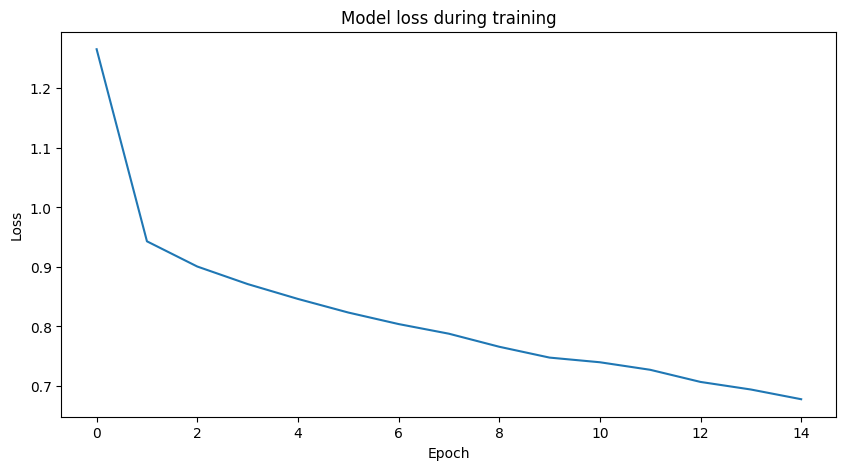

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss history
def plot_loss(loss_values):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values)
    plt.title('Model loss during training')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_loss(loss_values)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert scores to class predictions
y_pred = np.argmax(y_score, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

NameError: ignored

# We then check a 3D dataset

In [ ]:
data_flag = 'vesselmnist3d'
download = True

# info = INFO[data_flag]
info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

class Transform3D:

    def __init__(self, mul=None):
        self.mul = mul

    def __call__(self, voxel):

        if self.mul == '0.5':
            voxel = voxel * 0.5
        elif self.mul == 'random':
            voxel = voxel * np.random.uniform()

        return voxel.astype(np.float32)

def model_to_syncbn(model):
    preserve_state_dict = model.state_dict()
    _convert_module_from_bn_to_syncbn(model)
    model.load_state_dict(preserve_state_dict)
    return model


def _convert_module_from_bn_to_syncbn(module):
    for child_name, child in module.named_children():
        if hasattr(nn, child.__class__.__name__) and \
            'batchnorm' in child.__class__.__name__.lower():
            TargetClass = globals()['Synchronized'+child.__class__.__name__]
            arguments = TargetClass.__init__.__code__.co_varnames[1:]
            kwargs = {k: getattr(child, k) for k in arguments}
            setattr(module, child_name, TargetClass(**kwargs))
        else:
            _convert_module_from_bn_to_syncbn(child)

In [ ]:
# transforms
train_transform = Transform3D(mul='random')
eval_transform = Transform3D(mul='0.5')

# load the data
train_dataset = DataClass(split='train', transform=train_transform, download=download)
test_dataset = DataClass(split='test', transform=eval_transform, download=download)

# train_dataset = DataClass(split='train',  download=download)
# test_dataset = DataClass(split='test',  download=download)

# encapsulate data into dataloader form
train_loader_3d = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval_3d = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader_3d = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /root/.medmnist/vesselmnist3d.npz


In [ ]:
# check if GPU is available

if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

In [ ]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [ ]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28]) torch.Size([128, 1])


In [ ]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

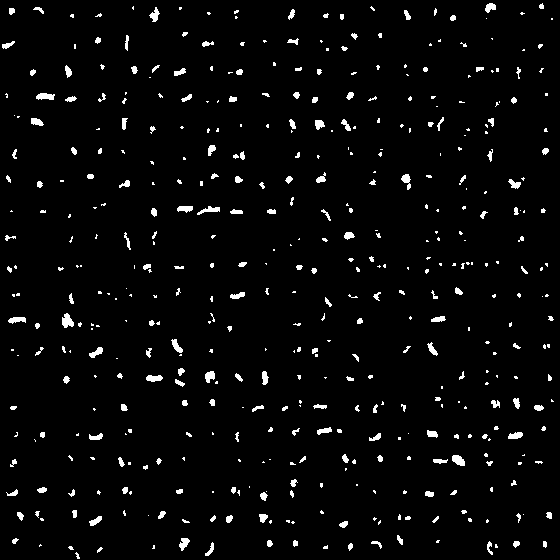

In [ ]:
frames = train_dataset.montage(length=20, save_folder="tmp/")
frames[10]

# Check [EXTERNAL] [`MedMNIST/experiments`](https://github.com/MedMNIST/experiments)

Training and evaluation scripts to reproduce both 2D and 3D experiments in our paper, including PyTorch, auto-sklearn, AutoKeras and Google AutoML Vision together with their weights ;)